In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import SparkConf
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

from partitioning import *
from utils import *


24/05/29 10:02:20 WARN Utils: Your hostname, yaozys-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.30.193.7 instead (on interface en0)
24/05/29 10:02:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/29 10:02:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Load Data

In [2]:
from sklearn.datasets import make_blobs

# Generate random dataset with 3 dimensions
n_samples = 100  # Number of samples
n_features = 3  # Number of dimensions
centers = 10  # Number of clusters
random_state = 42  # Random state for reproducibility

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
X = X.tolist()

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data.tolist()


# 2. Set parameter

In [4]:
# set parameters

# random dataset
# min_pts = 5
# eps = 5
# n_features = len(X[0])
# n_pa_each_dim = [3 for i in range(n_features)]

# iris dataset
min_pts = 5
eps = 0.5
n_features = len(X[0])
n_pa_each_dim = [2 for i in range(n_features)]

In [5]:
# dbscan from sklearn
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=min_pts)
dbscan.fit(X)
# evaluate
from sklearn.metrics import silhouette_score
silhouette_score(X, dbscan.labels_)
# dbscan.labels_


0.2779400139443986

# 3. Parallelize Data

In [10]:
rdd = sc.parallelize(X)
rdd = rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

# min_pts = sc.broadcast(min_pts)
# eps = sc.broadcast(eps)
# n_pa_each_dim = sc.broadcast(n_pa_each_dim)
# n_features = sc.broadcast(n_features)


# 4. Construct grid cells and locate points into cell

In [17]:
# construct the grid
min_max_bounds = get_minmax_by_data(X)
n_grid_each_dim = cal_grid_num(min_max_bounds, eps)
grid_bin_bounds = get_bin_bounds(min_max_bounds, n_grid_each_dim)

# locate the points
# grid_rdd = rdd.map(lambda x: (find_location_id(x, grid_bin_bounds, n_grid_each_dim), x))
grid_rdd = rdd.map(lambda x: (find_location_id(x[1], grid_bin_bounds, n_grid_each_dim), (x[0], x[1])))

# group the points inside each grid
grid_rdd = grid_rdd.groupByKey().mapValues(list)
grid_rdd.cache()
grid_rdd.take(10)

[((1, 4, 1, 0),
  [(2, [4.7, 3.2, 1.3, 0.2]),
   (3, [4.6, 3.1, 1.5, 0.2]),
   (47, [4.6, 3.2, 1.4, 0.2])]),
 ((3, 6, 1, 0), [(19, [5.1, 3.8, 1.5, 0.3]), (48, [5.3, 3.7, 1.5, 0.2])]),
 ((10, 4, 14, 4), [(50, [7.0, 3.2, 4.7, 1.4])]),
 ((2, 1, 8, 3), [(57, [4.9, 2.4, 3.3, 1.0]), (93, [5.0, 2.3, 3.3, 1.0])]),
 ((6, 0, 11, 3), [(62, [6.0, 2.2, 4.0, 1.0])]),
 ((9, 4, 13, 4), [(65, [6.7, 3.1, 4.4, 1.4])]),
 ((7, 1, 15, 5), [(72, [6.3, 2.5, 4.9, 1.5])]),
 ((4, 1, 10, 3), [(80, [5.5, 2.4, 3.8, 1.1]), (81, [5.5, 2.4, 3.7, 1.0])]),
 ((9, 4, 14, 5), [(86, [6.7, 3.1, 4.7, 1.5])]),
 ((5, 3, 12, 4),
  [(88, [5.6, 3.0, 4.1, 1.3]),
   (95, [5.7, 3.0, 4.2, 1.2]),
   (96, [5.7, 2.9, 4.2, 1.3])])]

In [18]:
grid_rdd.partitioner.partitionFunc

<function pyspark.rdd.portable_hash(x: Hashable) -> int>

# 5. Partition data

In [19]:
# allocate grid into partitions

def add_partition_id(x, grid_bins, n_pa_each_dim, buffer_size):
    buffer_loc_id = find_buffer_location_id(x[0], grid_bins, n_pa_each_dim, buffer_size)
    buffer_loc_id = list(set(buffer_loc_id))
    return [(blid, (x[0], x[1])) for blid in buffer_loc_id]

def get_partitioned_cells(rdd, grid_bins, n_pa_each_dim, buffer_size):
    rdd1 = rdd.flatMap(lambda x: add_partition_id(x, grid_bins, n_pa_each_dim, buffer_size))
    partitioned_rdd = rdd1.groupByKey().mapValues(list)
    # partitioned_rdd = rdd1.sortByKey()
    return partitioned_rdd

# divide the grid into partitions
grid_min_max = np.array(([0 for _ in range(len(n_grid_each_dim))], [i-1 for i in n_grid_each_dim])).T
grid_bins = get_bin_bounds(grid_min_max, n_pa_each_dim)

# buffer size (number of cells to be included in half of the buffer region)
buffer_size = int(np.ceil(eps/cal_grid_side_len(eps, n_features)))
partitioned_rdd = get_partitioned_cells(grid_rdd, grid_bins, n_pa_each_dim, buffer_size)
partitioned_rdd.glom().take(2)

[[((1, 1, 1, 1),
   [((10, 4, 14, 4), [(50, [7.0, 3.2, 4.7, 1.4])]),
    ((9, 4, 13, 4), [(65, [6.7, 3.1, 4.4, 1.4])]),
    ((9, 4, 14, 5), [(86, [6.7, 3.1, 4.7, 1.5])]),
    ((5, 3, 12, 4),
     [(88, [5.6, 3.0, 4.1, 1.3]),
      (95, [5.7, 3.0, 4.2, 1.2]),
      (96, [5.7, 2.9, 4.2, 1.3])]),
    ((9, 3, 17, 7), [(112, [6.8, 3.0, 5.5, 2.1])]),
    ((8, 4, 16, 8), [(115, [6.4, 3.2, 5.3, 2.3])]),
    ((10, 4, 18, 8), [(120, [6.9, 3.2, 5.7, 2.3])]),
    ((9, 4, 17, 8), [(140, [6.7, 3.1, 5.6, 2.4])]),
    ((8, 3, 16, 7), [(147, [6.5, 3.0, 5.2, 2.0])]),
    ((6, 3, 13, 5), [(78, [6.0, 2.9, 4.5, 1.5])]),
    ((7, 3, 17, 6), [(103, [6.3, 2.9, 5.6, 1.8])]),
    ((12, 3, 21, 7), [(105, [7.6, 3.0, 6.6, 2.1])]),
    ((7, 4, 14, 5), [(56, [6.3, 3.3, 4.7, 1.6])]),
    ((6, 4, 14, 6), [(70, [5.9, 3.2, 4.8, 1.8])]),
    ((9, 4, 18, 7), [(124, [6.7, 3.3, 5.7, 2.1])]),
    ((11, 4, 19, 6), [(125, [7.2, 3.2, 6.0, 1.8])]),
    ((10, 4, 17, 7), [(139, [6.9, 3.1, 5.4, 2.1])]),
    ((9, 4, 19, 8), [(143, [

In [23]:
print("Partitioner: ",partitioned_rdd.partitioner.partitionFunc)
print("Partition number: ", partitioned_rdd.getNumPartitions())

Partitioner:  <function portable_hash at 0x7fc99b8be290>
Partition number:  8


# 6. Identify Core Point

In [26]:
partitioned_rdd.collect()

[((1, 1, 1, 1),
  [((10, 4, 14, 4), [(50, [7.0, 3.2, 4.7, 1.4])]),
   ((9, 4, 13, 4), [(65, [6.7, 3.1, 4.4, 1.4])]),
   ((9, 4, 14, 5), [(86, [6.7, 3.1, 4.7, 1.5])]),
   ((5, 3, 12, 4),
    [(88, [5.6, 3.0, 4.1, 1.3]),
     (95, [5.7, 3.0, 4.2, 1.2]),
     (96, [5.7, 2.9, 4.2, 1.3])]),
   ((9, 3, 17, 7), [(112, [6.8, 3.0, 5.5, 2.1])]),
   ((8, 4, 16, 8), [(115, [6.4, 3.2, 5.3, 2.3])]),
   ((10, 4, 18, 8), [(120, [6.9, 3.2, 5.7, 2.3])]),
   ((9, 4, 17, 8), [(140, [6.7, 3.1, 5.6, 2.4])]),
   ((8, 3, 16, 7), [(147, [6.5, 3.0, 5.2, 2.0])]),
   ((6, 3, 13, 5), [(78, [6.0, 2.9, 4.5, 1.5])]),
   ((7, 3, 17, 6), [(103, [6.3, 2.9, 5.6, 1.8])]),
   ((12, 3, 21, 7), [(105, [7.6, 3.0, 6.6, 2.1])]),
   ((7, 4, 14, 5), [(56, [6.3, 3.3, 4.7, 1.6])]),
   ((6, 4, 14, 6), [(70, [5.9, 3.2, 4.8, 1.8])]),
   ((9, 4, 18, 7), [(124, [6.7, 3.3, 5.7, 2.1])]),
   ((11, 4, 19, 6), [(125, [7.2, 3.2, 6.0, 1.8])]),
   ((10, 4, 17, 7), [(139, [6.9, 3.1, 5.4, 2.1])]),
   ((9, 4, 19, 8), [(143, [6.8, 3.2, 5.9, 2.3])])

In [27]:
# find core points in each partition
def find_core_points(pa, eps, min_pts):
    pa = list(pa)
    for p in pa:
        pid = p[0]
        grids = p[1]
        
        points = []
        for grid in grids:
            for p in grid[1]:
                points.append([pid, grid[0], p])
                
        for paid, gid, (pid,value) in points:
            count = 0
            core_flag = 0
            for _, _, (_,value2) in points:
                if value == value2:
                    continue
                if np.linalg.norm(np.array(value) - np.array(value2)) <= eps:
                    count += 1
                    if count >= min_pts:
                        core_flag = 1
                        break
            yield ((paid, gid), (pid, value), core_flag)

points_with_flag = partitioned_rdd.mapPartitions(lambda x: find_core_points(x, eps, min_pts))
points_with_flag.take(10)


[(((1, 1, 1, 1), (10, 4, 14, 4)), (50, [7.0, 3.2, 4.7, 1.4]), 0),
 (((1, 1, 1, 1), (9, 4, 13, 4)), (65, [6.7, 3.1, 4.4, 1.4]), 1),
 (((1, 1, 1, 1), (9, 4, 14, 5)), (86, [6.7, 3.1, 4.7, 1.5]), 1),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (88, [5.6, 3.0, 4.1, 1.3]), 0),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (95, [5.7, 3.0, 4.2, 1.2]), 0),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (96, [5.7, 2.9, 4.2, 1.3]), 1),
 (((1, 1, 1, 1), (9, 3, 17, 7)), (112, [6.8, 3.0, 5.5, 2.1]), 1),
 (((1, 1, 1, 1), (8, 4, 16, 8)), (115, [6.4, 3.2, 5.3, 2.3]), 1),
 (((1, 1, 1, 1), (10, 4, 18, 8)), (120, [6.9, 3.2, 5.7, 2.3]), 1),
 (((1, 1, 1, 1), (9, 4, 17, 8)), (140, [6.7, 3.1, 5.6, 2.4]), 1)]

In [28]:
points_with_flag.partitioner

# 7. Find core cells

In [30]:
# find core cells with at least one core point in each partition

def find_core_cells(pa):
    pa = list(pa)
    core_cells = {}
    for key, point, flag in pa:
        if flag == 1:
            if key not in core_cells:
                core_cells[key] = []
            core_cells[key].append(point)
    for key in core_cells:
        yield ((key[0], key[1]), core_cells[key])
    
core_cells = points_with_flag.mapPartitions(lambda x: find_core_cells(x))
core_cells.take(10)


[(((1, 1, 1, 1), (9, 4, 13, 4)), [(65, [6.7, 3.1, 4.4, 1.4])]),
 (((1, 1, 1, 1), (9, 4, 14, 5)), [(86, [6.7, 3.1, 4.7, 1.5])]),
 (((1, 1, 1, 1), (5, 3, 12, 4)), [(96, [5.7, 2.9, 4.2, 1.3])]),
 (((1, 1, 1, 1), (9, 3, 17, 7)), [(112, [6.8, 3.0, 5.5, 2.1])]),
 (((1, 1, 1, 1), (8, 4, 16, 8)), [(115, [6.4, 3.2, 5.3, 2.3])]),
 (((1, 1, 1, 1), (10, 4, 18, 8)), [(120, [6.9, 3.2, 5.7, 2.3])]),
 (((1, 1, 1, 1), (9, 4, 17, 8)), [(140, [6.7, 3.1, 5.6, 2.4])]),
 (((1, 1, 1, 1), (8, 3, 16, 7)), [(147, [6.5, 3.0, 5.2, 2.0])]),
 (((1, 1, 1, 1), (6, 3, 13, 5)), [(78, [6.0, 2.9, 4.5, 1.5])]),
 (((1, 1, 1, 1), (7, 4, 14, 5)), [(56, [6.3, 3.3, 4.7, 1.6])])]

In [31]:
# adopted to avoid shuffling (reduceByKey)

# core_cells = points_with_flag.map(lambda x: (x[0], x[2]))\
#                               .reduceByKey(lambda x, y: x+y)\
#                                 .filter(lambda x: x[1] > 0)
# core_cells.take(10)

In [33]:
core_cells.collect()

[(((1, 1, 1, 1), (9, 4, 13, 4)), [(65, [6.7, 3.1, 4.4, 1.4])]),
 (((1, 1, 1, 1), (9, 4, 14, 5)), [(86, [6.7, 3.1, 4.7, 1.5])]),
 (((1, 1, 1, 1), (5, 3, 12, 4)), [(96, [5.7, 2.9, 4.2, 1.3])]),
 (((1, 1, 1, 1), (9, 3, 17, 7)), [(112, [6.8, 3.0, 5.5, 2.1])]),
 (((1, 1, 1, 1), (8, 4, 16, 8)), [(115, [6.4, 3.2, 5.3, 2.3])]),
 (((1, 1, 1, 1), (10, 4, 18, 8)), [(120, [6.9, 3.2, 5.7, 2.3])]),
 (((1, 1, 1, 1), (9, 4, 17, 8)), [(140, [6.7, 3.1, 5.6, 2.4])]),
 (((1, 1, 1, 1), (8, 3, 16, 7)), [(147, [6.5, 3.0, 5.2, 2.0])]),
 (((1, 1, 1, 1), (6, 3, 13, 5)), [(78, [6.0, 2.9, 4.5, 1.5])]),
 (((1, 1, 1, 1), (7, 4, 14, 5)), [(56, [6.3, 3.3, 4.7, 1.6])]),
 (((1, 1, 1, 1), (6, 4, 14, 6)), [(70, [5.9, 3.2, 4.8, 1.8])]),
 (((1, 1, 1, 1), (9, 4, 18, 7)), [(124, [6.7, 3.3, 5.7, 2.1])]),
 (((1, 1, 1, 1), (10, 4, 17, 7)), [(139, [6.9, 3.1, 5.4, 2.1])]),
 (((1, 1, 1, 1), (9, 4, 19, 8)), [(143, [6.8, 3.2, 5.9, 2.3])]),
 (((1, 1, 1, 1), (9, 4, 18, 8)), [(144, [6.7, 3.3, 5.7, 2.5])]),
 (((1, 1, 1, 1), (6, 3, 12, 5

# 8. Find eps-neighbor cell pair

In [34]:
def get_distance_matrix(points1, points2):
    distance_matrix = np.zeros((len(points1), len(points2)))
    for i in range(len(points1)):
        for j in range(len(points2)):
            distance_matrix[i][j] = np.linalg.norm(np.array(points1[i]) - np.array(points2[j]))
    return distance_matrix

def find_neighbor_cell(pa, eps):
    pa = list(pa)
    partitions = {}
    
    for (paid, gid), points in pa:
        if paid not in partitions:
            partitions[paid] = []
        partitions[paid].append((gid, points))
    
    for pid, grids in partitions.items():
        for i, (gid, points) in enumerate(grids):
            point_values = [p[1] for p in points]
            for gid2, points2 in grids[i+1:]:
                point_values2 = [p[1] for p in points2]
                distance_matrix = get_distance_matrix(point_values, point_values2)
                isNeighbor = np.sum(distance_matrix <= eps)
                if isNeighbor >= 1:
                    yield (pid, gid, gid2)

neighbor_pairs = core_cells.mapPartitions(lambda x: find_neighbor_cell(x, eps))
neighbor_pairs.collect()

[((1, 1, 1, 1), (9, 4, 13, 4), (9, 4, 14, 5)),
 ((1, 1, 1, 1), (9, 4, 13, 4), (8, 3, 13, 4)),
 ((1, 1, 1, 1), (9, 4, 13, 4), (8, 3, 12, 4)),
 ((1, 1, 1, 1), (9, 4, 13, 4), (8, 4, 13, 5)),
 ((1, 1, 1, 1), (9, 4, 13, 4), (8, 3, 14, 4)),
 ((1, 1, 1, 1), (9, 4, 14, 5), (7, 4, 14, 5)),
 ((1, 1, 1, 1), (9, 4, 14, 5), (8, 3, 13, 4)),
 ((1, 1, 1, 1), (9, 4, 14, 5), (8, 4, 13, 5)),
 ((1, 1, 1, 1), (9, 4, 14, 5), (8, 3, 14, 4)),
 ((1, 1, 1, 1), (5, 3, 12, 4), (6, 3, 13, 5)),
 ((1, 1, 1, 1), (5, 3, 12, 4), (6, 3, 12, 5)),
 ((1, 1, 1, 1), (5, 3, 12, 4), (5, 3, 13, 5)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (10, 4, 18, 8)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (9, 4, 17, 8)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (8, 3, 16, 7)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (9, 4, 18, 7)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (10, 4, 17, 7)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (9, 4, 19, 8)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (9, 3, 16, 8)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (8, 3, 18, 7)),
 ((1, 1, 1, 1), (9, 3, 17, 7), (8, 3, 17, 6)),
 ((1, 1, 1,

# 9. Create a graph

In [35]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame
spark = SparkSession.builder.appName("ApproxDBSCAN").getOrCreate()


In [36]:
# dict to store the mapping between tuple index and integer index
# transform the index before using graphframes

pos_to_gid, gid_to_pos = grid_index_mapping(n_grid_each_dim)
pos_to_paid, paid_to_pos = grid_index_mapping(n_pa_each_dim)

In [37]:
# create vertices and edges

v = core_cells.map(lambda x: (pos_to_paid[x[0][0]], pos_to_gid[x[0][1]],)).toDF(["paid", "id"])
v = v.repartition(int(np.prod(n_pa_each_dim)), "paid")
e = neighbor_pairs.map(lambda x: (pos_to_paid[x[0]], pos_to_gid[x[1]], pos_to_gid[x[2]])).toDF(["paid", "src", "dst"])
e = e.repartition(int(np.prod(n_pa_each_dim)), "paid")

# create graph
g = GraphFrame(v, e)
g.edges.show()

/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----+-----+-----+
|paid|  src|  dst|
+----+-----+-----+
|   9|10048| 9840|
|   9|10048| 9841|
|   9|10048|11912|
|   9|10048| 9832|
|   9|10048|13558|
|   9| 9840| 9841|
|   9| 9840| 9624|
|   9| 9840| 9832|
|   9| 9840|13558|
|   9| 9841|11912|
|   9| 9841| 9624|
|   9| 9841| 9832|
|   9| 9841|13558|
|   9|11912|13558|
|   9| 9624| 9832|
|   9| 9832|13558|
|  11|17716|17726|
|  11|17716|15449|
|  11|17716|15646|
|  11|17716|15637|
+----+-----+-----+
only showing top 20 rows



In [91]:
# set Checkpoint directory
sc.setCheckpointDir("checkpoints")

# compute connected components
# not optimal to use connectedComponents(), since it will shuffle the data and lose the partition.
# TODO: New implementation is required for computing connected component.
result = g.connectedComponents()
result.show()


/Users/yaozeyi/anaconda3/envs/py310/lib/python3.10/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+----+-----+---------+
|paid|   id|component|
+----+-----+---------+
|   9|10048|     7752|
|   9| 9840|     7752|
|   9| 9841|     7752|
|   9|11912|     7752|
|   9| 9624|     7752|
|   9| 9832|     7752|
|   9|13558|     7752|
|  11|17716|     7752|
|  11|13388|     7752|
|  11|17726|     7752|
|  11|10048|     7752|
|  11|15468|     7752|
|  11|17548|     7752|
|  11|15884|     7752|
|  11|19628|     7752|
|  11|17756|     7752|
|  11|15676|     7752|
|  11|11921|     7752|
|  11|13821|     7752|
|  11| 9871|     7752|
+----+-----+---------+
only showing top 20 rows



# 10. Merge 

In [38]:
points_with_flag.collect()

[(((1, 1, 1, 1), (10, 4, 14, 4)), (50, [7.0, 3.2, 4.7, 1.4]), 0),
 (((1, 1, 1, 1), (9, 4, 13, 4)), (65, [6.7, 3.1, 4.4, 1.4]), 1),
 (((1, 1, 1, 1), (9, 4, 14, 5)), (86, [6.7, 3.1, 4.7, 1.5]), 1),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (88, [5.6, 3.0, 4.1, 1.3]), 0),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (95, [5.7, 3.0, 4.2, 1.2]), 0),
 (((1, 1, 1, 1), (5, 3, 12, 4)), (96, [5.7, 2.9, 4.2, 1.3]), 1),
 (((1, 1, 1, 1), (9, 3, 17, 7)), (112, [6.8, 3.0, 5.5, 2.1]), 1),
 (((1, 1, 1, 1), (8, 4, 16, 8)), (115, [6.4, 3.2, 5.3, 2.3]), 1),
 (((1, 1, 1, 1), (10, 4, 18, 8)), (120, [6.9, 3.2, 5.7, 2.3]), 1),
 (((1, 1, 1, 1), (9, 4, 17, 8)), (140, [6.7, 3.1, 5.6, 2.4]), 1),
 (((1, 1, 1, 1), (8, 3, 16, 7)), (147, [6.5, 3.0, 5.2, 2.0]), 1),
 (((1, 1, 1, 1), (6, 3, 13, 5)), (78, [6.0, 2.9, 4.5, 1.5]), 1),
 (((1, 1, 1, 1), (7, 3, 17, 6)), (103, [6.3, 2.9, 5.6, 1.8]), 0),
 (((1, 1, 1, 1), (12, 3, 21, 7)), (105, [7.6, 3.0, 6.6, 2.1]), 0),
 (((1, 1, 1, 1), (7, 4, 14, 5)), (56, [6.3, 3.3, 4.7, 1.6]), 1),
 (((1, 1, 1, 1)

In [44]:
# remove duplicates
# result = result.dropDuplicates(['id'])

def remove_duplicates(x):
    gid = x[0]
    points = x[1]
    points_flag = {}
    for p in points:
        if p[0] not in points_flag:
            points_flag[p[0]] = p[1]
        else:
            if (p[1] == 1)&(points_flag[p[0]] == 0):
                points_flag[p[0]] = 1
    for k, v in points_flag.items():
        yield (gid, (k, v))
    # return (gid, [(k, v) for k, v in points_flag.items()])
                

points_flagged = points_with_flag.map(lambda x: (pos_to_gid[x[0][1]], (x[1][0], x[2])))
points_flagged = points_flagged.groupByKey().mapValues(list)
points_flagged = points_flagged.flatMap(lambda x: remove_duplicates(x))
points_flagged.collect()

[(10048, (88, 1)),
 (10048, (95, 1)),
 (10048, (96, 1)),
 (14000, (56, 1)),
 (11912, (61, 1)),
 (13792, (63, 1)),
 (13792, (91, 1)),
 (17528, (77, 1)),
 (14048, (100, 0)),
 (11280, (62, 0)),
 (9840, (67, 1)),
 (9624, (69, 1)),
 (9832, (82, 1)),
 (9832, (92, 1)),
 (7752, (80, 1)),
 (7752, (81, 1)),
 (9664, (113, 0)),
 (9872, (114, 0)),
 (4008, (57, 0)),
 (4008, (93, 0)),
 (8496, (36, 1)),
 (216, (41, 0)),
 (6840, (19, 1)),
 (6840, (48, 1)),
 (8920, (5, 1)),
 (11921, (78, 1)),
 (25657, (131, 0)),
 (19601, (141, 0)),
 (21281, (129, 0)),
 (9841, (94, 1)),
 (9841, (99, 1)),
 (13369, (87, 0)),
 (15449, (54, 1)),
 (13585, (73, 1)),
 (6633, (0, 1)),
 (6633, (17, 1)),
 (6633, (27, 1)),
 (6633, (28, 1)),
 (6633, (39, 1)),
 (8497, (31, 1)),
 (8505, (20, 1)),
 (6841, (21, 1)),
 (6849, (46, 1)),
 (12138, (70, 1)),
 (21498, (125, 0)),
 (19618, (139, 1)),
 (25666, (117, 0)),
 (10058, (66, 1)),
 (15874, (110, 1)),
 (9850, (55, 1)),
 (6106, (59, 0)),
 (7762, (53, 1)),
 (7762, (89, 1)),
 (4554, (35, 1))

In [93]:
len(set(points_flagged.keys().collect()))

123

# 11. Assign points to clusters

In [94]:
cluster = result.rdd.map(lambda x: (x[1], x[2]))\
                        .join(points_flagged)\
                        .map(lambda x: (x[1][0], x[1][1][0], x[1][1][1]))
cluster_df = cluster.toDF(["cluster_id", "point_id", "core_flag"])
cluster_df.show()


+----------+--------+---------+
|cluster_id|point_id|core_flag|
+----------+--------+---------+
|       630|      33|        1|
|       630|       2|        1|
|       630|       3|        1|
|       630|      47|        1|
|       630|      32|        1|
|       630|       9|        1|
|       630|      34|        1|
|       630|      49|        1|
|       630|      29|        1|
|       630|      30|        1|
|       630|      12|        1|
|       630|      45|        1|
|       630|       4|        1|
|       630|       7|        1|
|       630|      37|        1|
|       630|      40|        1|
|       630|      36|        1|
|       630|      24|        1|
|       630|      19|        1|
|       630|      48|        1|
+----------+--------+---------+
only showing top 20 rows



# 12. Evaluation

In [95]:
# cluster_df to pandas dataframe
import pandas as pd
from evaluate import *
from sklearn.cluster import DBSCAN

df = pd.DataFrame(list(range(len(X))), columns=["point_id"])
df.head()

,point_id
0,0
1,1
2,2
3,3
4,4


In [96]:
result = df.merge(cluster_df.toPandas(), on="point_id", how="left")
result = result.fillna(-1)
result.head()

,point_id,cluster_id,core_flag
0,0,630.0,1.0
1,1,630.0,1.0
2,2,630.0,1.0
3,3,630.0,1.0
4,4,630.0,1.0


In [97]:
# dbscan from sklearn

dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(X)
result["sklearn_cluster"] = dbscan.labels_
result.head()

,point_id,cluster_id,core_flag,sklearn_cluster
0,0,630.0,1.0,0
1,1,630.0,1.0,0
2,2,630.0,1.0,0
3,3,630.0,1.0,0
4,4,630.0,1.0,0


In [98]:
result['cluster_id'].unique()

array([ 6.300e+02, -1.000e+00,  7.752e+03])

In [99]:
# compare

ari, ami, sc = evaluate(X, result["cluster_id"], result["sklearn_cluster"])

ARI: 0.6207
AMI: 0.6544
Silhouette Coefficient: 0.4860


# 13. visualization

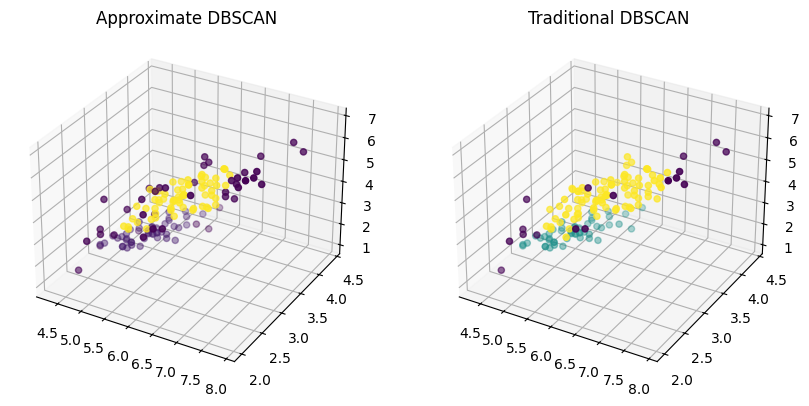

In [100]:
# visualization of the clustering result
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.array(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=result["cluster_id"].astype(int))
ax.set_title("Approximate DBSCAN")
ax1 = fig.add_subplot(122, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=result["sklearn_cluster"].astype(int))
ax1.set_title("Traditional DBSCAN")
plt.savefig("figs/compareDBSCAN.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()
